# Reading & Understanding Data
## Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

## Loading Dataset

In [6]:
df = pd.read_csv('features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## About dataset

In [7]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,pop,1000
1,jazz,1000
2,reggae,1000
3,blues,1000
4,metal,1000
5,disco,999
6,rock,998
7,hiphop,998
8,classical,998
9,country,997


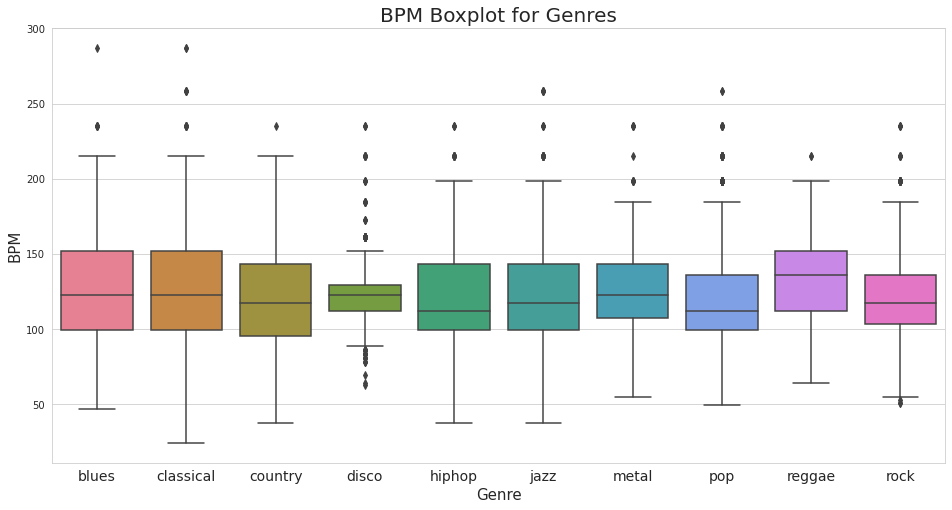

In [8]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

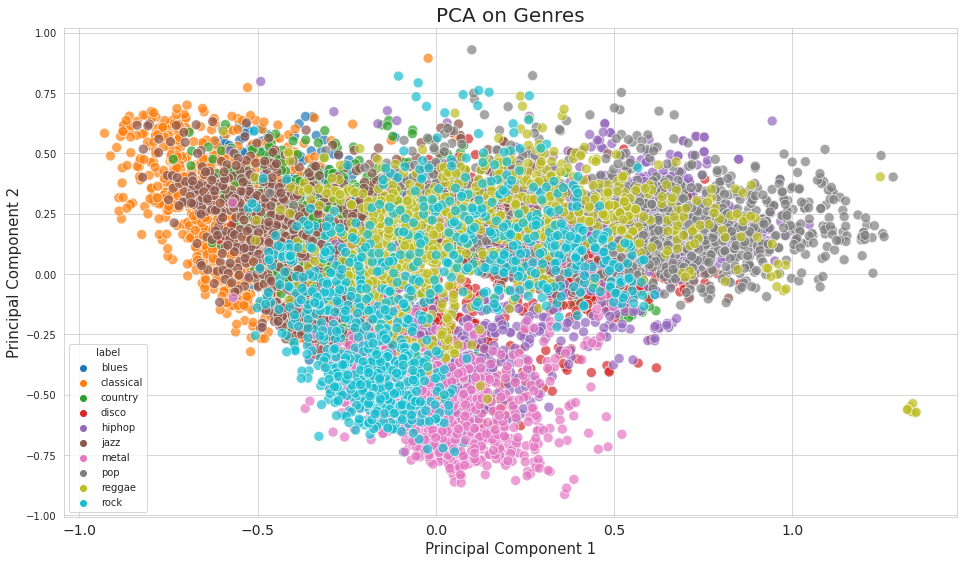

In [9]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [10]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


## Encode Genre Label

In [11]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [12]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train Dev & Test Sets

In [13]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [14]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [15]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [16]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [17]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Feature Selection

## Sample Logistic Regression Model

Building model with all the available features.

In [22]:
def predictProba(clf, X, dev=False):
    y_true = y_train
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    #skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    #plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

              precision    recall  f1-score   support

           0      0.709     0.749     0.728       700
           1      0.918     0.940     0.929       699
           2      0.663     0.640     0.652       698
           3      0.684     0.681     0.682       699
           4      0.758     0.678     0.716       699
           5      0.796     0.833     0.814       700
           6      0.835     0.870     0.852       700
           7      0.794     0.810     0.802       700
           8      0.684     0.679     0.681       700
           9      0.568     0.549     0.558       698

    accuracy                          0.743      6993
   macro avg      0.741     0.743     0.742      6993
weighted avg      0.741     0.743     0.742      6993

              precision    recall  f1-score   support

           0      0.648     0.753     0.696       198
           1      0.945     0.955     0.950       198
           2      0.650     0.604     0.626       197
           3      0.630 

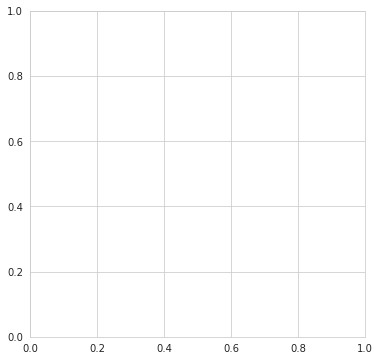

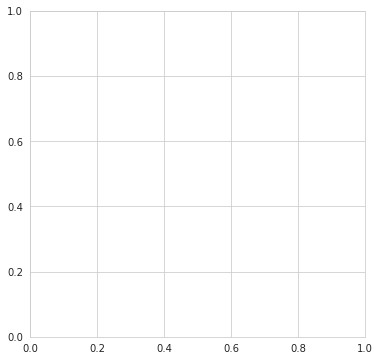

In [23]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

## Permutation Importance Feature Selection

In [24]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.1856 ± 0.0067,mfcc1_mean
0.1751 ± 0.0134,spectral_centroid_mean
0.1610 ± 0.0034,rms_mean
0.1532 ± 0.0070,spectral_bandwidth_mean
0.1409 ± 0.0118,rolloff_mean
0.1294 ± 0.0072,zero_crossing_rate_mean
0.0982 ± 0.0028,perceptr_var
0.0952 ± 0.0031,mfcc3_mean
0.0905 ± 0.0050,chroma_stft_mean
0.0847 ± 0.0040,mfcc2_mean


#### Plot Permutation Importances

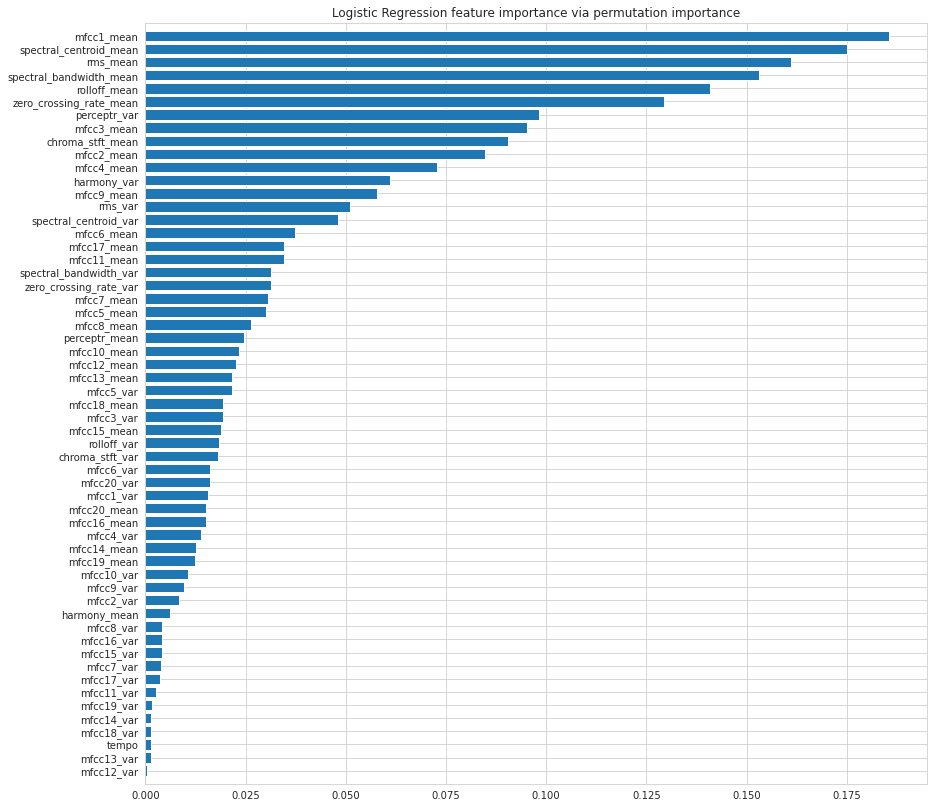

In [25]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()

#### Model Score using Permutation Importances

              precision    recall  f1-score   support

           0      0.656     0.707     0.681       700
           1      0.888     0.921     0.904       699
           2      0.601     0.577     0.589       698
           3      0.619     0.624     0.622       699
           4      0.702     0.628     0.663       699
           5      0.738     0.791     0.764       700
           6      0.799     0.864     0.830       700
           7      0.762     0.769     0.765       700
           8      0.615     0.613     0.614       700
           9      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.599     0.538     0.567       197
           3      0.591 

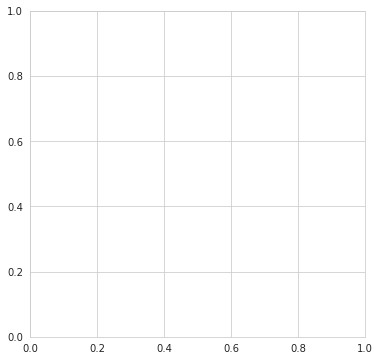

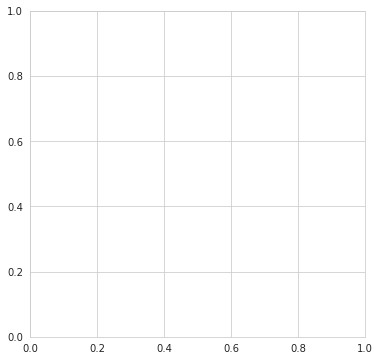

In [26]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)

## Correlation Heatmap

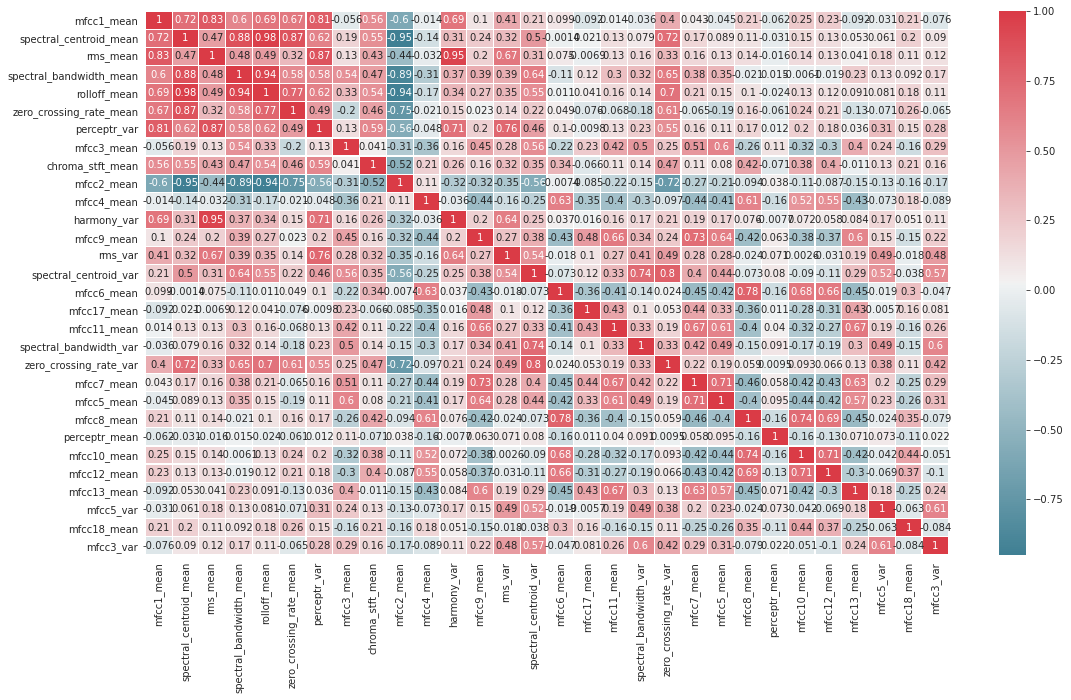

In [27]:
# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

# Model Building

## Logistic Regression

              precision    recall  f1-score   support

           0      0.656     0.707     0.681       700
           1      0.888     0.921     0.904       699
           2      0.601     0.577     0.589       698
           3      0.619     0.624     0.622       699
           4      0.702     0.628     0.663       699
           5      0.738     0.791     0.764       700
           6      0.799     0.864     0.830       700
           7      0.762     0.769     0.765       700
           8      0.615     0.613     0.614       700
           9      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



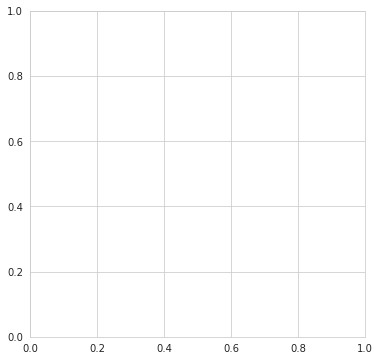

In [28]:
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe)

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.599     0.538     0.567       197
           3      0.591     0.621     0.606       198
           4      0.669     0.543     0.599       197
           5      0.723     0.843     0.779       198
           6      0.774     0.848     0.810       198
           7      0.818     0.793     0.805       198
           8      0.608     0.641     0.624       198
           9      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



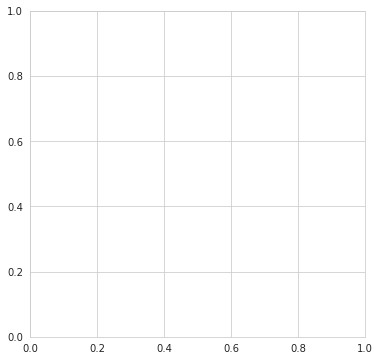

In [29]:
predictProba(lr, X_train_rfe, True)

## Random Forest

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.994     0.999     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



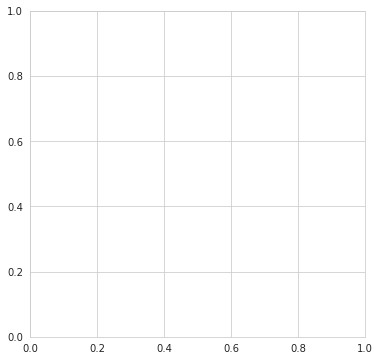

In [30]:
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe)

              precision    recall  f1-score   support

           0      0.869     0.838     0.853       198
           1      0.936     0.965     0.950       198
           2      0.769     0.843     0.804       197
           3      0.865     0.838     0.851       198
           4      0.928     0.853     0.889       197
           5      0.852     0.904     0.877       198
           6      0.893     0.929     0.911       198
           7      0.891     0.864     0.877       198
           8      0.841     0.884     0.862       198
           9      0.843     0.758     0.798       198

    accuracy                          0.868      1978
   macro avg      0.869     0.868     0.867      1978
weighted avg      0.869     0.868     0.867      1978



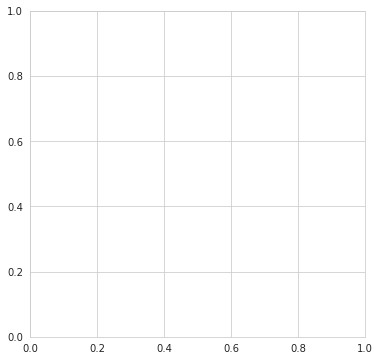

In [31]:
predictProba(rfc, X_train_rfe, True)

## AdaBoost

              precision    recall  f1-score   support

           0      0.394     0.531     0.453       700
           1      0.591     0.963     0.732       699
           2      0.323     0.125     0.180       698
           3      0.296     0.375     0.331       699
           4      0.372     0.250     0.299       699
           5      0.558     0.309     0.397       700
           6      0.577     0.876     0.695       700
           7      0.462     0.794     0.584       700
           8      0.407     0.231     0.295       700
           9      0.294     0.099     0.148       698

    accuracy                          0.455      6993
   macro avg      0.427     0.455     0.412      6993
weighted avg      0.428     0.455     0.412      6993



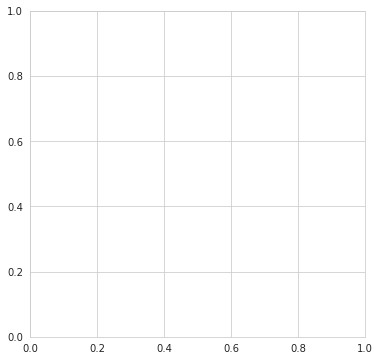

In [32]:
abc = ske.AdaBoostClassifier(n_estimators=100, random_state=seed)
abc.fit(X_train_rfe, y_train)
predictProba(abc, X_train_rfe)

              precision    recall  f1-score   support

           0      0.338     0.475     0.395       198
           1      0.595     0.934     0.727       198
           2      0.295     0.132     0.182       197
           3      0.361     0.414     0.386       198
           4      0.344     0.228     0.274       197
           5      0.578     0.338     0.427       198
           6      0.575     0.874     0.693       198
           7      0.453     0.788     0.576       198
           8      0.317     0.167     0.219       198
           9      0.385     0.152     0.217       198

    accuracy                          0.450      1978
   macro avg      0.424     0.450     0.410      1978
weighted avg      0.424     0.450     0.410      1978



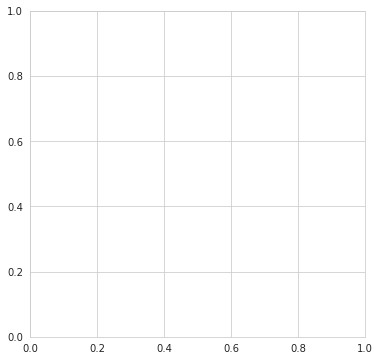

In [33]:
predictProba(abc, X_train_rfe, True)

## GBM

              precision    recall  f1-score   support

           0      0.949     0.957     0.953       700
           1      0.989     0.990     0.989       699
           2      0.884     0.924     0.903       698
           3      0.884     0.903     0.893       699
           4      0.934     0.926     0.930       699
           5      0.936     0.964     0.950       700
           6      0.978     0.970     0.974       700
           7      0.977     0.959     0.968       700
           8      0.913     0.930     0.921       700
           9      0.923     0.840     0.879       698

    accuracy                          0.936      6993
   macro avg      0.937     0.936     0.936      6993
weighted avg      0.937     0.936     0.936      6993



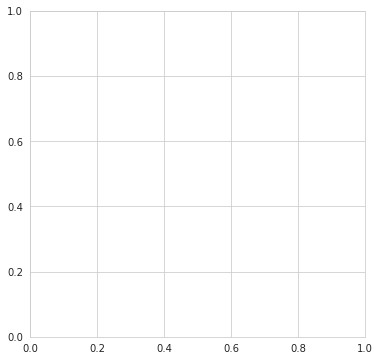

In [34]:
gbc = ske.GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbc.fit(X_train_rfe, y_train)
predictProba(gbc, X_train_rfe)

              precision    recall  f1-score   support

           0      0.813     0.768     0.790       198
           1      0.948     0.929     0.939       198
           2      0.690     0.746     0.717       197
           3      0.718     0.707     0.712       198
           4      0.779     0.716     0.746       197
           5      0.805     0.854     0.828       198
           6      0.871     0.889     0.880       198
           7      0.843     0.843     0.843       198
           8      0.722     0.788     0.754       198
           9      0.731     0.672     0.700       198

    accuracy                          0.791      1978
   macro avg      0.792     0.791     0.791      1978
weighted avg      0.792     0.791     0.791      1978



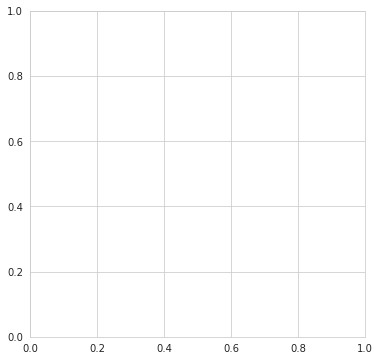

In [35]:
predictProba(gbc, X_train_rfe, True)

## XGBoost

In [37]:
import xgboost as xgb
print(xgb.__version__)

1.3.0


[20:51:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.997     0.996     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.996     0.997     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.

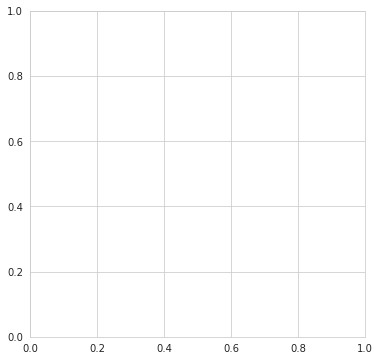

In [38]:
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
predictProba(xgbc, X_train_rfe)

              precision    recall  f1-score   support

           0      0.901     0.823     0.860       198
           1      0.939     0.939     0.939       198
           2      0.784     0.883     0.831       197
           3      0.872     0.823     0.847       198
           4      0.908     0.898     0.903       197
           5      0.882     0.904     0.893       198
           6      0.917     0.949     0.933       198
           7      0.891     0.864     0.877       198
           8      0.886     0.899     0.892       198
           9      0.814     0.798     0.806       198

    accuracy                          0.878      1978
   macro avg      0.879     0.878     0.878      1978
weighted avg      0.879     0.878     0.878      1978



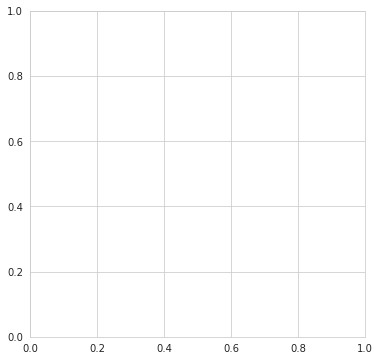

In [39]:
predictProba(xgbc, X_train_rfe, True)

## CatBoost

In [40]:
import catboost as cb
print(cb.__version__)

0.24.4


              precision    recall  f1-score   support

           0      1.000     0.999     0.999       700
           1      0.999     1.000     0.999       699
           2      0.999     1.000     0.999       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      0.999     0.999     0.999       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      0.999     0.999     0.999       700
           9      0.996     0.993     0.994       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



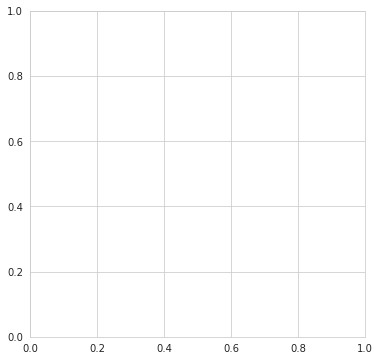

In [41]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

              precision    recall  f1-score   support

           0      0.915     0.874     0.894       198
           1      0.960     0.960     0.960       198
           2      0.833     0.888     0.860       197
           3      0.895     0.859     0.876       198
           4      0.918     0.904     0.910       197
           5      0.867     0.919     0.892       198
           6      0.930     0.944     0.937       198
           7      0.936     0.884     0.909       198
           8      0.857     0.909     0.882       198
           9      0.852     0.813     0.832       198

    accuracy                          0.895      1978
   macro avg      0.896     0.895     0.895      1978
weighted avg      0.896     0.895     0.895      1978



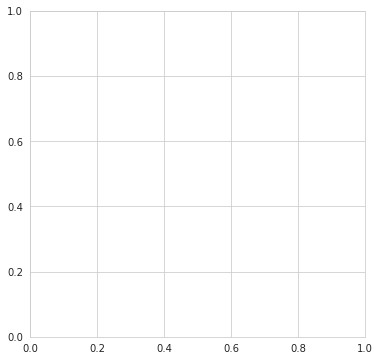

In [42]:
predictProba(cbc, X_train_rfe, True)

# Model Tuning

Tuning selected models which performed good as base models.

## RF Model HP Tuning

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 15, 30, 45, 60],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [10, 140, 270, 400]}


In [44]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=12),
             n_jobs=-1,
             param_grid={'max_depth': [1, 15, 30, 45, 60],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 140, 270, 400]},
             scoring='f1_weighted', verbose=2)

In [45]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=400,
                       n_jobs=-1, random_state=12)


              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      0.999     1.000     0.999       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     0.999     0.999       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



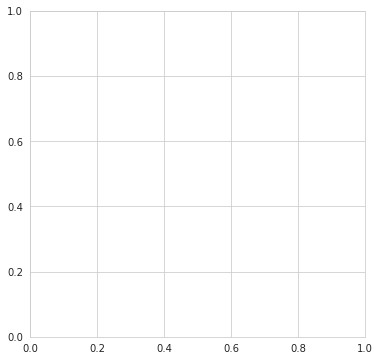

In [46]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe)

              precision    recall  f1-score   support

           0      0.872     0.828     0.850       198
           1      0.945     0.960     0.952       198
           2      0.766     0.832     0.798       197
           3      0.863     0.828     0.845       198
           4      0.901     0.832     0.865       197
           5      0.837     0.909     0.872       198
           6      0.863     0.919     0.890       198
           7      0.891     0.869     0.880       198
           8      0.826     0.889     0.856       198
           9      0.860     0.742     0.797       198

    accuracy                          0.861      1978
   macro avg      0.863     0.861     0.861      1978
weighted avg      0.863     0.861     0.861      1978



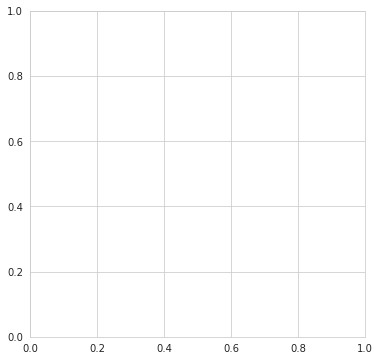

In [47]:
predictProba(rf_random.best_estimator_, X_train_rfe, True)

## XGB Model HP Tuning

In [48]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [49]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgb_model, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 23.6min finished


[21:38:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb483b11820>,
                                        'max_depth':

In [50]:
# best xgb_random model 
print(xgb_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9066782998097372,
              gamma=0.0016439843761698048, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3000310498970947,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=137, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=12,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.6023637423473936, tree_method='exact',
              validate_parameters=1, verbosity=None)


              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



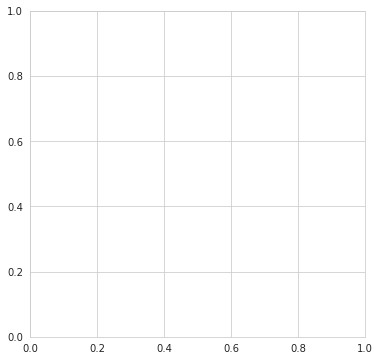

In [51]:
# Performance metrics
predictProba(xgb_random.best_estimator_, X_train_rfe)

              precision    recall  f1-score   support

           0      0.840     0.823     0.832       198
           1      0.969     0.944     0.957       198
           2      0.786     0.838     0.811       197
           3      0.833     0.833     0.833       198
           4      0.884     0.853     0.868       197
           5      0.859     0.889     0.873       198
           6      0.915     0.919     0.917       198
           7      0.935     0.869     0.901       198
           8      0.839     0.894     0.866       198
           9      0.820     0.803     0.811       198

    accuracy                          0.867      1978
   macro avg      0.868     0.867     0.867      1978
weighted avg      0.868     0.867     0.867      1978



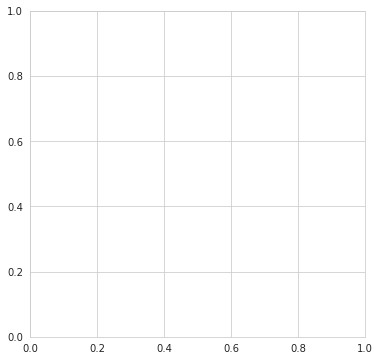

In [53]:
predictProba(xgb_random.best_estimator_, X_train_rfe, True)

# Model Evaluation

In [54]:
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.837     0.853     0.845       102
           1      0.898     0.960     0.928       101
           2      0.780     0.765     0.772       102
           3      0.905     0.843     0.873       102
           4      0.876     0.833     0.854       102
           5      0.841     0.882     0.861       102
           6      0.900     0.971     0.934       102
           7      0.903     0.912     0.907       102
           8      0.829     0.853     0.841       102
           9      0.811     0.716     0.760       102

    accuracy                          0.859      1019
   macro avg      0.858     0.859     0.858      1019
weighted avg      0.858     0.859     0.858      1019

RF Test Accuracy - 85.8684985279686


In [55]:
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.841     0.882     0.861       102
           1      0.916     0.970     0.942       101
           2      0.775     0.843     0.808       102
           3      0.883     0.892     0.888       102
           4      0.915     0.843     0.878       102
           5      0.888     0.853     0.870       102
           6      0.941     0.931     0.936       102
           7      0.913     0.931     0.922       102
           8      0.909     0.882     0.896       102
           9      0.811     0.755     0.782       102

    accuracy                          0.878      1019
   macro avg      0.879     0.878     0.878      1019
weighted avg      0.879     0.878     0.878      1019

XGB Test Accuracy - 87.83120706575073


In [56]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.867     0.892     0.879       102
           1      0.926     0.990     0.957       101
           2      0.800     0.824     0.812       102
           3      0.918     0.882     0.900       102
           4      0.946     0.863     0.903       102
           5      0.891     0.882     0.887       102
           6      0.961     0.971     0.966       102
           7      0.942     0.951     0.946       102
           8      0.877     0.912     0.894       102
           9      0.835     0.794     0.814       102

    accuracy                          0.896      1019
   macro avg      0.896     0.896     0.896      1019
weighted avg      0.896     0.896     0.896      1019

CatBoost Test Accuracy - 89.59764474975465


logistic regression: 0.69
Random Forest(Untuned): 0.86
Adaboost: 0.45
Gradient Boosting machine: 0.791
XGBoost(Untuned): 0.878
Catboost(Untuned): 0.89

RF(Tuned): 0.861
XGB(Tuned): 0.879
Catboost(Tuned): 0.896